In [1]:
!pip install pycuda

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 34.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.8/98.8 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.2/103.2 kB 12.2 MB/s eta 0:00:00
  Created wheel for pycuda: filename=pycuda-2025.1.2-cp312-cp312-linux_x86_64.whl size=659050 sha256=48e00a45f62f2b85b43fa035e0aa2860767f89f518a89a8e9f6975e7ebb327be
  Stored in directory: /root/.cache/pip/wheels/d5/36/f3/ac5f09d768cad3fa15d5a3449bdfe65c3de58e69d036c73228
Successfully built pycuda


In [2]:
import numpy as np
import pycuda.autoinit
from pycuda.compiler import SourceModule
import pycuda.driver as cuda
from PIL import Image
import matplotlib.pyplot as plt
import time


In [3]:
# @title
source_kernel="""

#define BLOCK_SIZE 16
#define channel 3

__constant__ float F_c[9] =  {
    -1, -2, -1,
     0,  0,  0,
     1,  2,  1
};


//Cuda kernel for 2D convolution with stencil, RGB image

__global__ void Conv2d_rgb_stencil (unsigned char *input, unsigned char *output, int width, int height)
{

   __shared__ unsigned char tile[BLOCK_SIZE+2][BLOCK_SIZE+2][channel];

  int tx = threadIdx.x;
  int ty = threadIdx.y;
  int col =blockIdx.x *blockDim.x + threadIdx.x;
  int row =blockIdx.y *blockDim.y + threadIdx.y;

  if (row<height && col<width)
  {
    for (int c =0 ; c<channel; c++)
    {
      //Load the center pixel
      tile[ty+1][tx+1][c]= input[(row*width + col)*channel + c];

      //Halo Pixels
      if (tx==0 && col>0)
          tile [ty+1][0][c]=input [(row*width + (col-1))*channel+ c];
      if (tx ==BLOCK_SIZE-1 && col < width -1)
          tile[ty+1][BLOCK_SIZE+1][c]= input[(row*width+(col+1))*channel+c];
      if (ty==0&&row>0)
          tile[0][tx+1][c] = input[((row-1)*width + col)*channel + c];
      if (ty==BLOCK_SIZE-1 && row <height -1)
           tile[BLOCK_SIZE+1][tx+1][c]= input[((row+1)*width+col)*channel+c];
    }
  }

  __syncthreads();

  if (row<height && col<width)
  {
    for (int c =0 ; c<channel; c++)
    {
      float sum =0.0f;
      for(int ky = -1; ky <= 1; ky++) {
                for(int kx = -1; kx <= 1; kx++) {
                    int shared_x = tx + 1 + kx;
                    int shared_y = ty + 1 + ky;

                    // Clamp within tile bounds
                    shared_x = max(0, min(shared_x, BLOCK_SIZE+1));
                    shared_y = max(0, min(shared_y, BLOCK_SIZE+1));

                    float pixel = (float)tile[shared_y][shared_x][c];
                    float coeff = F_c[(ky+1)*3 + (kx+1)];
                    sum += pixel * coeff;
                }
            }
            sum = min(max(sum, 0.0f), 255.0f);
            output[(row*width + col)*channel + c] = (unsigned char)sum;
    }
  }
}
"""

In [4]:
print("Compiling the CUDA Kernel....")
#compile the cuda

mode =  SourceModule(source_kernel)

#Get the compiler function from the compile module
Conv2d_rgb_stencil= mode.get_function('Conv2d_rgb_stencil')


print("kernel compiled successfully")

Compiling the CUDA Kernel....
kernel compiled successfully


The matrix of Bukayo Saka is now initialised


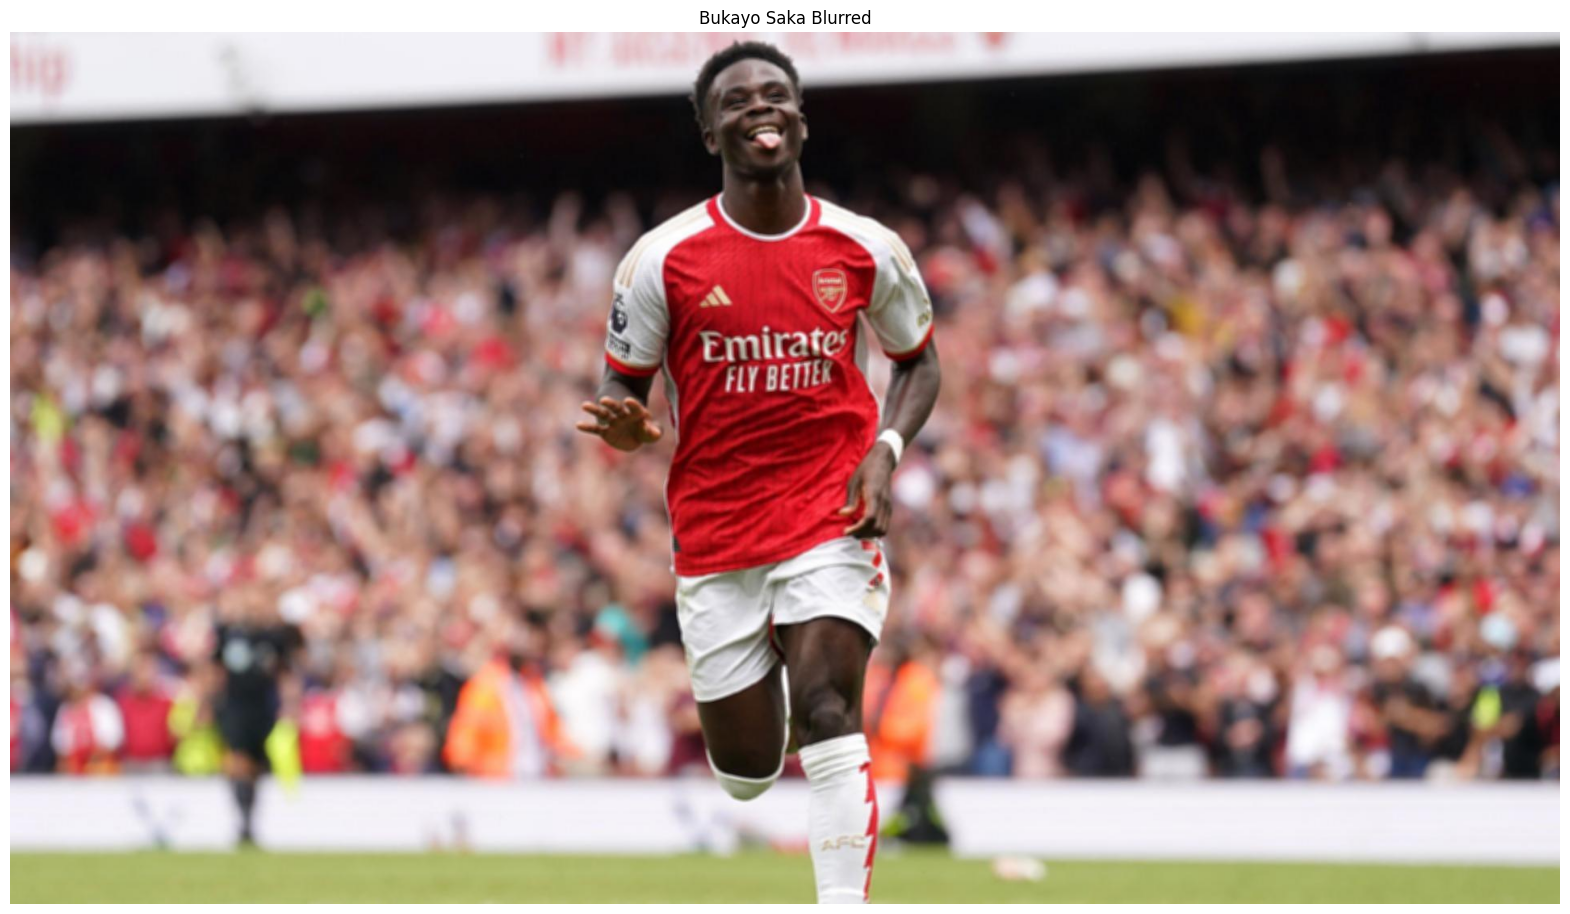

In [5]:
#Load the image
image = np.array(Image.open('saka_blurred.jpg'))
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 15))
plt.axis("off")
plt.title("Bukayo Saka Blurred")
ax.imshow(image)
print("The matrix of Bukayo Saka is now initialised")

In [6]:
#print the shape of the input array
print(f'The shape of the input array is {image.shape}')

#Initialise an empy array for result
empty_sample_output=np.empty_like(image)

print('\nEmpty output image is initialised')

The shape of the input array is (1080, 1920, 3)

Empty output image is initialised


In [7]:
#Allocate memory in GPY

p_in= cuda.mem_alloc(image.nbytes)
p_out=cuda.mem_alloc(empty_sample_output.nbytes)

print("memory allocated in GPU")

memory allocated in GPU


In [8]:
#Transfer Data from CPu to Gpu
print("Copy the image to GPU form the CPU")
cuda.memcpy_htod(p_in,image)
print("\nCopying completed")

Copy the image to GPU form the CPU

Copying completed


In [9]:
#Execute the kernel in GPU
print("\nExecuting the parallel programming in GPU")
#Define the Block and grid dimension in GPU to process
# A block is a group of  threads . A grid is a group of blocks
BLOCK_SIZE=(16,16,1)
GRID_SIZE = (
    (image.shape[1]+BLOCK_SIZE[0]-1)//BLOCK_SIZE[0],
    (image.shape[0]+BLOCK_SIZE[0]-1)//BLOCK_SIZE[0]
    )

#Start the time

gpu_start_time= time.time()

#Call the Kernel
Conv2d_rgb_stencil(p_in,p_out,np.int32(image.shape[1]),np.int32(image.shape[0]),block =BLOCK_SIZE,grid=GRID_SIZE)

#Wait for the GPU to Finish the Process
cuda.Context.synchronize()

#stop the timer
gpu_endtime= time.time()

gpu_execution_time=(gpu_endtime-gpu_start_time)
print("\nExection in GPU completed :)")




Executing the parallel programming in GPU

Exection in GPU completed :)


In [10]:
#Copying the result from thr GPU to CPU
print("Copying the result back to CPU")
empty_sample_output=np.empty_like(image)
cuda.memcpy_dtoh(empty_sample_output,p_out)
print("copied successfully to CPU")


Copying the result back to CPU
copied successfully to CPU


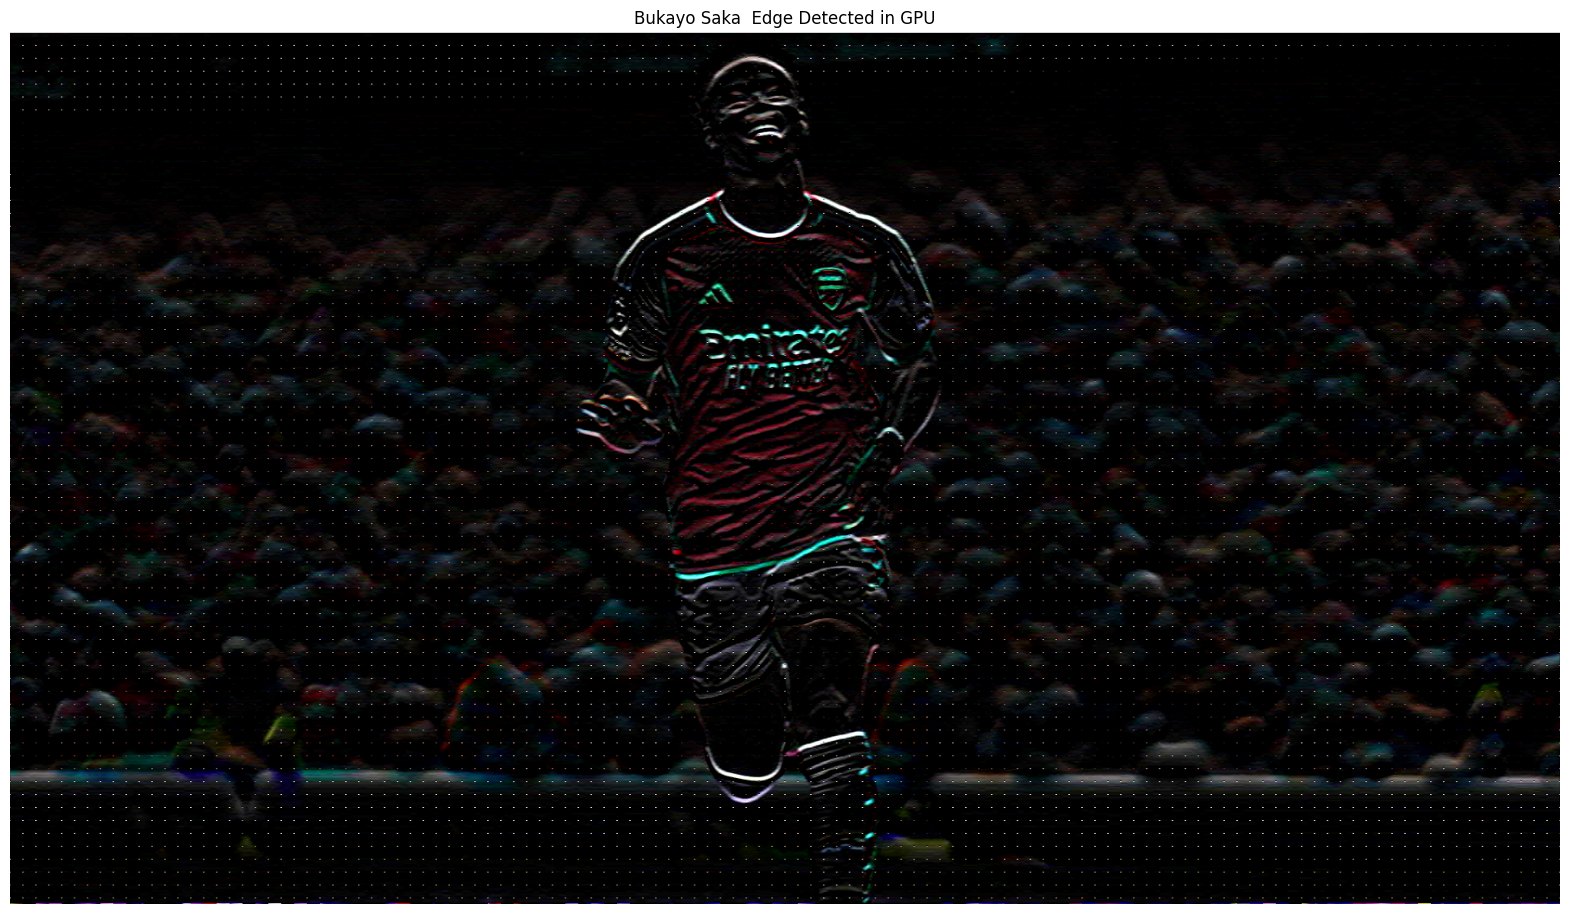

The matrix of Bukayo Saka is now is the Edge Detected matrix


In [11]:
#Show the blurred Bukayo Saka
axes= plt.Figure(figsize=(10,9))
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 15))
plt.axis("off")
plt.title("Bukayo Saka  Edge Detected in GPU")
ax.imshow(empty_sample_output)
plt.axis("off")
plt.show()
print("The matrix of Bukayo Saka is now is the Edge Detected matrix")

CPU convolution time: 25.1161 seconds


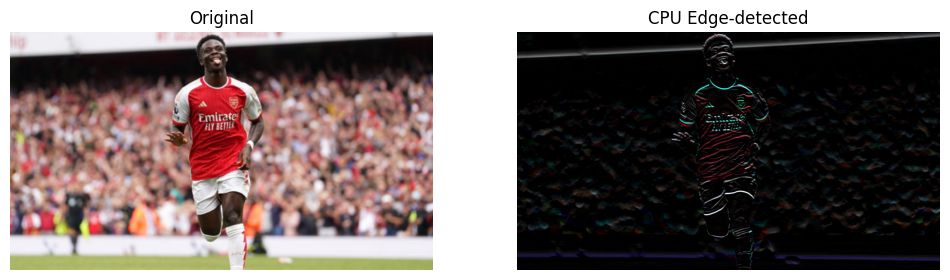

Saved saka_edge_cpu.png


In [12]:
# CPU implementation of the 3x3 edge-detection kernel and timing
import time
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

K = np.array([[-1, -2, -1],[0,0,0],[1,2,1]], dtype=np.float32)

def conv2d_rgb_cpu(image, kernel=K, padding='replicate'):
    if image.dtype != np.uint8:
        raise ValueError('Input image must be uint8')
    if image.ndim != 3 or image.shape[2] != 3:
        raise ValueError('Input must be H x W x 3 RGB image')

    h, w, _ = image.shape
    out = np.zeros_like(image, dtype=np.uint8)
    img_f = image.astype(np.float32)
    pad = 1

    if padding == 'zero':
        padded = np.zeros((h+2*pad, w+2*pad, 3), dtype=np.float32)
        padded[pad:pad+h, pad:pad+w, :] = img_f
    elif padding == 'replicate':
        padded = np.zeros((h+2*pad, w+2*pad, 3), dtype=np.float32)
        padded[pad:pad+h, pad:pad+w, :] = img_f
        # replicate top/bottom
        padded[:pad, pad:pad+w, :] = img_f[0:1, :, :]
        padded[pad+h:, pad:pad+w, :] = img_f[h-1:h, :, :]
        # replicate left/right (including corners)
        padded[:, :pad, :] = padded[:, pad:pad+1, :]
        padded[:, pad+w:, :] = padded[:, pad+w-1:pad+w, :]
    else:
        raise ValueError("padding must be 'zero' or 'replicate'")

    k = np.flipud(np.fliplr(kernel))

    for y in range(h):
        for x in range(w):
            region = padded[y:y+3, x:x+3, :]
            res = (region * k[:, :, None]).sum(axis=(0,1))
            res = np.clip(res, 0, 255)
            out[y, x, :] = res.astype(np.uint8)

    return out

# Load image (same file used earlier in notebook)
img = Image.open('saka_blurred.jpg').convert('RGB')
img_np = np.array(img)

# Time the CPU convolution
t0 = time.time()
out_cpu = conv2d_rgb_cpu(img_np, padding='replicate')
t1 = time.time()
print(f'CPU convolution time: {t1 - t0:.4f} seconds')

time_taken_cpu=t1 - t0

# Display and save
fig, ax = plt.subplots(1,2, figsize=(12,6))
ax[0].imshow(img_np)
ax[0].set_title('Original')
ax[0].axis('off')
ax[1].imshow(out_cpu)
ax[1].set_title('CPU Edge-detected')
ax[1].axis('off')
plt.show()
Image.fromarray(out_cpu).save('saka_edge_cpu.png')
print('Saved saka_edge_cpu.png')


In [13]:
print(f"Time taken in GPU is {gpu_execution_time} \nTime taken in CPU is {time_taken_cpu}")

Time taken in GPU is 0.004114627838134766 
Time taken in CPU is 25.116116046905518
